<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/HookedCursiveTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HookedCursiveTransformer

# Setup

In [1]:
!pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
!pip install transformer_lens
!pip install gradio
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install datasets

# Clone the cursivetransformer repository and install its requirements
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git
!pip install -r cursivetransformer/requirements.txt

# Login to Weights & Biases (replace 'your_api_key' with your actual API key)
import wandb
wandb.login()

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-bahiixfa
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-bahiixfa
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for circuitsvis: filename=circuitsvis-0.0.0-py3-none-any.whl size=6172334 sha256=59415c32edc93016c6c42f3b4833706a3be43b700e7573be5495cc7c0ec5f306
  Stored in directory: /tmp/pip-ephem-wheel-cache-90w2ssyb/wheels/86/be/ad/78078aba9344d200aad61b63d35cdaecdec160212f039eed74
Successfully built circuitsvis
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 8.5.0
    Uninstalling importlib_metadata-8.5.0:
      Successfully uninstalled importlib_metadata-8.5.0
INFO: p

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [22]:
import sys
sys.path.append('/content/cursivetransformer')  # Adjust the path if necessary

import os
import einops
import torch
import torch.nn as nn
import torch.nn.functional as F
import types
import matplotlib.pyplot as plt
import circuitsvis as cv
from IPython.display import display
import seaborn as sns

from cursivetransformer.model import get_all_args, get_checkpoint, get_latest_checkpoint_artifact
from cursivetransformer.data import create_datasets, offsets_to_strokes
from cursivetransformer.sample import generate, generate_n_words, plot_strokes
from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint
from transformer_lens.utils import get_act_name

from transformer_lens.utilities.attention import simple_attn_linear

from typing import Callable, Dict, Optional, Union

import torch
import torch.nn as nn
from jaxtyping import Float, Int

from transformer_lens.components import (
    Attention,
    GroupedQueryAttention,
    LayerNorm,
    LayerNormPre,
    RMSNorm,
    RMSNormPre,
    Embed,
    Unembed
)
from transformer_lens.components.mlps.can_be_used_as_mlp import CanBeUsedAsMLP
# from transformer_lens.factories.mlp_factory import MLPFactory
from transformer_lens.hook_points import HookPoint
from transformer_lens.HookedTransformerConfig import HookedTransformerConfig
from transformer_lens.past_key_value_caching import HookedTransformerKeyValueCacheEntry
from transformer_lens.utils import repeat_along_head_dimension

from typing import Dict, Union

import torch
import torch.nn as nn
from jaxtyping import Float

from transformer_lens.components.mlps.can_be_used_as_mlp import CanBeUsedAsMLP
from transformer_lens.hook_points import HookPoint
from transformer_lens.HookedTransformerConfig import HookedTransformerConfig
from transformer_lens.utilities.addmm import batch_addmm

In [3]:
# Usage example:
args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'  # Replace with your actual run ID
args.wandb_entity = 'sam-greydanus'
args.dataset_name = 'bigbank'  # Replace with your dataset name
args.wandb_run_name = 'cursivetransformer_dictionary_learning'

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)

args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()

Trying to load dataset file from /content/cursivetransformer/data/bigbank.json.zip
Succeeded in loading the bigbank dataset; contains 1900 items.
For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples


In [32]:
class HookedCursiveTransformerConfig(HookedTransformerConfig):
    def __init__(self, **kwargs):
        # Extract custom arguments
        self.d_model_c = kwargs.pop('d_model_c', None)
        self.context_block_size = kwargs.pop('context_block_size', None)
        self.context_vocab_size = kwargs.pop('context_vocab_size', None)
        self.use_cross_attention = kwargs.pop('use_cross_attention', True)

        # W&B specific parameters
        self.wandb_entity = kwargs.pop('wandb_entity', None)
        self.wandb_project = kwargs.pop('wandb_project', None)
        self.load_from_run_id = kwargs.pop('load_from_run_id', None)

        # Now, call the superclass constructor with the remaining kwargs
        super().__init__(**kwargs)

    @classmethod
    def from_dict(cls, config_dict):
        return cls(**config_dict)

class HookedCursiveTransformer(HookedTransformer):
    def __init__(self, cfg):
        super().__init__(cfg)
        self.cfg = cfg

        # Embedding layers
        self.embed = nn.Embedding(cfg.d_vocab, cfg.d_model)
        self.pos_embed = nn.Embedding(cfg.n_ctx, cfg.d_model)
        self.embed_c = nn.Embedding(cfg.context_vocab_size, cfg.d_model_c)
        self.pos_embed_c = nn.Embedding(cfg.context_block_size, cfg.d_model_c)

        # Projection layer if d_model_c != d_model
        if cfg.d_model_c != cfg.d_model:
            self.context_proj = nn.Linear(cfg.d_model_c, cfg.d_model)
        else:
            self.context_proj = nn.Identity()

        # Blocks
        self.blocks = nn.ModuleList([TransformerBlock(cfg, block_index=_) for _ in range(cfg.n_layers)])

        # Final layers
        self.ln_final = nn.LayerNorm(cfg.d_model)
        self.unembed = nn.Linear(cfg.d_model, cfg.d_vocab, bias=True)

        # Hook points
        self.hook_embed = HookPoint()
        self.hook_pos_embed = HookPoint()
        self.hook_embed_c = HookPoint()
        self.hook_pos_embed_c = HookPoint()

        self.setup()

    def forward(self, tokens, context, return_type="logits"):
        B, T = tokens.shape
        B_c, T_c = context.shape

        token_embed = self.hook_embed(self.embed(tokens))
        pos_embed = self.hook_pos_embed(self.pos_embed(torch.arange(T, device=tokens.device)))
        x = token_embed + pos_embed

        context_embed = self.hook_embed_c(self.embed_c(context))
        context_pos_embed = self.hook_pos_embed_c(self.pos_embed_c(torch.arange(T_c, device=context.device)))
        c = context_embed + context_pos_embed
        c = self.context_proj(c)

        # Generate causal mask
        causal_mask = torch.tril(torch.ones((T, T), device=tokens.device)).unsqueeze(0).unsqueeze(0)
        causal_mask = causal_mask.to(dtype=torch.bool)

        for block in self.blocks:
            x = block(x, c, attention_mask=causal_mask)

        x = self.ln_final(x)
        logits = self.unembed(x)

        if return_type == "logits":
            return logits
        elif return_type == "loss":
            return self.loss_fn(logits, tokens[:, 1:])
        elif return_type == "both":
            return logits, self.loss_fn(logits, tokens[:, 1:])
        else:
            raise ValueError(f"Invalid return_type {return_type}")

    @classmethod
    def from_pretrained(
        cls,
        model_name: str,
        cfg,
        tokenizer=None,
        **from_pretrained_kwargs
    ):
        """
        Load a pretrained CursiveTransformer model into the HookedCursiveTransformer format.

        Args:
            model_name (str): The name or path of the pretrained model.
            cfg: The configuration object for the model.
            tokenizer: The tokenizer to use (optional).
            **from_pretrained_kwargs: Additional keyword arguments.

        Returns:
            HookedCursiveTransformer: The loaded model.
        """
        print(f"Loading pretrained model {model_name}")

        # Initialize the HookedCursiveTransformer with the given config
        model = cls(cfg)

        # Load the state dict from the wandb artifact
        state_dict = cls.load_state_dict_from_wandb(cfg)

        # Convert the state dict to match HookedCursiveTransformer format
        converted_state_dict = cls.convert_cursivetransformer_weights(state_dict, cfg)

        # Load the converted state dict into the model
        model.load_state_dict(converted_state_dict, strict=False)

        if tokenizer is not None:
            model.tokenizer = tokenizer

        print(f"Successfully loaded pretrained model {model_name}")
        return model

    @staticmethod
    def load_state_dict_from_wandb(args):
        artifact = get_latest_checkpoint_artifact(args)
        artifact_dir = artifact.download()
        checkpoint = torch.load(os.path.join(artifact_dir, "best_checkpoint.pt"), weights_only=True)
        return checkpoint['model_state_dict']

    @staticmethod
    def convert_cursivetransformer_weights(state_dict, cfg):
        """Convert CursiveTransformer weights to HookedCursiveTransformer format."""
        new_state_dict = {}

        # Embeddings
        new_state_dict["embed.W_E"] = state_dict["transformer.wte.weight"]
        new_state_dict["pos_embed.W_pos"] = state_dict["transformer.wpe.weight"]
        new_state_dict["embed_c.W_E"] = state_dict["transformer.wce.weight"]
        new_state_dict["pos_embed_c.W_pos"] = state_dict["transformer.wcpe.weight"]

        for l in range(cfg.n_layers):
            # Layer Norms
            new_state_dict[f'blocks.{l}.ln1.w'] = state_dict[f'transformer.h.{l}.ln_1.weight']
            new_state_dict[f'blocks.{l}.ln1.b'] = state_dict[f'transformer.h.{l}.ln_1.bias']
            new_state_dict[f'blocks.{l}.ln2.w'] = state_dict[f'transformer.h.{l}.ln_2.weight']
            new_state_dict[f'blocks.{l}.ln2.b'] = state_dict[f'transformer.h.{l}.ln_2.bias']
            new_state_dict[f'blocks.{l}.ln3.w'] = state_dict[f'transformer.h.{l}.ln_3.weight']
            new_state_dict[f'blocks.{l}.ln3.b'] = state_dict[f'transformer.h.{l}.ln_3.bias']

            # Self-Attention
            W_qkv = state_dict[f'transformer.h.{l}.attn.c_attn.weight']
            b_qkv = state_dict[f'transformer.h.{l}.attn.c_attn.bias']
            W_q, W_k, W_v = W_qkv.t().chunk(3, dim=1)
            b_q, b_k, b_v = b_qkv.chunk(3, dim=0)

            new_state_dict[f'blocks.{l}.attn.W_Q'] = W_q.t().reshape(cfg.n_heads, cfg.d_model, cfg.d_head)
            new_state_dict[f'blocks.{l}.attn.W_K'] = W_k.t().reshape(cfg.n_heads, cfg.d_model, cfg.d_head)
            new_state_dict[f'blocks.{l}.attn.W_V'] = W_v.t().reshape(cfg.n_heads, cfg.d_model, cfg.d_head)
            new_state_dict[f'blocks.{l}.attn.b_Q'] = b_q.reshape(cfg.n_heads, cfg.d_head)
            new_state_dict[f'blocks.{l}.attn.b_K'] = b_k.reshape(cfg.n_heads, cfg.d_head)
            new_state_dict[f'blocks.{l}.attn.b_V'] = b_v.reshape(cfg.n_heads, cfg.d_head)

            W_o = state_dict[f'transformer.h.{l}.attn.c_proj.weight']
            new_state_dict[f'blocks.{l}.attn.W_O'] = W_o.t().reshape(cfg.n_heads, cfg.d_head, cfg.d_model)
            new_state_dict[f'blocks.{l}.attn.b_O'] = state_dict[f'transformer.h.{l}.attn.c_proj.bias']

            # Cross-Attention
            W_q = state_dict[f'transformer.h.{l}.cross_attn.c_attn_q.weight']
            b_q = state_dict[f'transformer.h.{l}.cross_attn.c_attn_q.bias']
            new_state_dict[f'blocks.{l}.cross_attn.W_Q'] = W_q.t().reshape(cfg.n_heads, cfg.d_model, cfg.d_head)
            new_state_dict[f'blocks.{l}.cross_attn.b_Q'] = b_q.reshape(cfg.n_heads, cfg.d_head)

            W_kv = state_dict[f'transformer.h.{l}.cross_attn.c_attn_kv.weight']
            b_kv = state_dict[f'transformer.h.{l}.cross_attn.c_attn_kv.bias']
            W_k, W_v = W_kv.t().chunk(2, dim=1)
            b_k, b_v = b_kv.chunk(2, dim=0)

            new_state_dict[f'blocks.{l}.cross_attn.W_K'] = W_k.t().reshape(cfg.n_heads, cfg.d_model_c, cfg.d_head)
            new_state_dict[f'blocks.{l}.cross_attn.W_V'] = W_v.t().reshape(cfg.n_heads, cfg.d_model_c, cfg.d_head)
            new_state_dict[f'blocks.{l}.cross_attn.b_K'] = b_k.reshape(cfg.n_heads, cfg.d_head)
            new_state_dict[f'blocks.{l}.cross_attn.b_V'] = b_v.reshape(cfg.n_heads, cfg.d_head)

            W_o = state_dict[f'transformer.h.{l}.cross_attn.c_proj.weight']
            new_state_dict[f'blocks.{l}.cross_attn.W_O'] = W_o.t().reshape(cfg.n_heads, cfg.d_head, cfg.d_model)
            new_state_dict[f'blocks.{l}.cross_attn.b_O'] = state_dict[f'transformer.h.{l}.cross_attn.c_proj.bias']

            # MLP
            new_state_dict[f'blocks.{l}.mlp.W_in'] = state_dict[f'transformer.h.{l}.mlp.c_fc.weight'].t()
            new_state_dict[f'blocks.{l}.mlp.b_in'] = state_dict[f'transformer.h.{l}.mlp.c_fc.bias']
            new_state_dict[f'blocks.{l}.mlp.W_out'] = state_dict[f'transformer.h.{l}.mlp.c_proj.weight'].t()
            new_state_dict[f'blocks.{l}.mlp.b_out'] = state_dict[f'transformer.h.{l}.mlp.c_proj.bias']

        # Final layer norm and unembedding
        new_state_dict["ln_final.w"] = state_dict["transformer.ln_f.weight"]
        new_state_dict["ln_final.b"] = state_dict["transformer.ln_f.bias"]
        new_state_dict["unembed.W_U"] = state_dict["lm_head.weight"].t()
        new_state_dict["unembed.b_U"] = state_dict.get("lm_head.bias", torch.zeros(cfg.d_vocab))

        return new_state_dict

    def loss_fn(self, logits, targets):
        return F.cross_entropy(logits[:, :-1, :].reshape(-1, logits.size(-1)), targets.reshape(-1), ignore_index=-1)

class TransformerBlock(nn.Module):
    def __init__(self, cfg: Union[Dict, HookedTransformerConfig], block_index):
        super().__init__()
        self.cfg = HookedCursiveTransformerConfig.unwrap(cfg)

        # Determine normalization type
        if self.cfg.normalization_type == "LN":
            normalization_layer = LayerNorm
        elif self.cfg.normalization_type == "LNPre":
            normalization_layer = LayerNormPre
        elif self.cfg.normalization_type == "RMS":
            normalization_layer = RMSNorm
        elif self.cfg.normalization_type == "RMSPre":
            normalization_layer = RMSNormPre
        elif self.cfg.normalization_type is None:
            normalization_layer = lambda cfg: nn.Identity()
        else:
            raise ValueError(f"Invalid normalization_type: {self.cfg.normalization_type}")

        # Initialize layers
        self.ln1 = normalization_layer(cfg)
        self.ln2 = normalization_layer(cfg)
        self.ln3 = normalization_layer(cfg)

        attention_class = Attention
        cross_attention_class = CrossAttention
        self.attn = attention_class(self.cfg, "global", block_index)
        self.cross_attn = cross_attention_class(self.cfg, "global", block_index)
        self.mlp = MLPFactory.create_mlp(self.cfg)

        # Hook points
        self.hook_attn_in = HookPoint()
        self.hook_cross_attn_in = HookPoint()
        self.hook_mlp_in = HookPoint()
        self.hook_attn_out = HookPoint()
        self.hook_cross_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid1 = HookPoint()
        self.hook_resid_mid2 = HookPoint()
        self.hook_resid_post = HookPoint()

    def forward(
        self,
        resid_pre: Float[torch.Tensor, "batch pos d_model"],
        context: Float[torch.Tensor, "batch context_len d_model_c"],
        attention_mask: Optional[Int[torch.Tensor, "batch 1 seq_len seq_len"]] = None,
    ) -> Float[torch.Tensor, "batch pos d_model"]:
        resid_pre = self.hook_resid_pre(resid_pre)

        # Self-attention
        attn_in = self.hook_attn_in(resid_pre)
        normalized_attn_in = self.ln1(attn_in)
        attn_out = self.attn(
            query_input=normalized_attn_in,
            key_input=normalized_attn_in,
            value_input=normalized_attn_in,
            attention_mask=attention_mask,
        )
        attn_out = self.hook_attn_out(attn_out)
        resid_mid1 = self.hook_resid_mid1(resid_pre + attn_out)

        # Cross-attention
        cross_attn_in = self.hook_cross_attn_in(resid_mid1)
        normalized_cross_attn_in = self.ln2(cross_attn_in)
        cross_attn_out = self.cross_attn(
            query_input=normalized_cross_attn_in,
            key_input=context,
            value_input=context,
            attention_mask=None,  # No mask for cross-attention
        )
        cross_attn_out = self.hook_cross_attn_out(cross_attn_out)
        resid_mid2 = self.hook_resid_mid2(resid_mid1 + cross_attn_out)

        # MLP
        mlp_in = self.hook_mlp_in(resid_mid2)
        normalized_mlp_in = self.ln3(mlp_in)
        mlp_out = self.mlp(normalized_mlp_in)
        mlp_out = self.hook_mlp_out(mlp_out)

        resid_post = self.hook_resid_post(resid_mid2 + mlp_out)
        return resid_post

class CrossAttention(Attention):
    def __init__(self, cfg, attn_type='global', layer_id=None):
        super().__init__(cfg, attn_type, layer_id)
        self.cfg = cfg

        # Initialize W_K and W_V for cross-attention with d_model_c
        self.W_K = nn.Parameter(
            torch.empty(
                self.cfg.n_heads, self.cfg.d_model_c, self.cfg.d_head, dtype=self.cfg.dtype
            )
        )
        self.W_V = nn.Parameter(
            torch.empty(
                self.cfg.n_heads, self.cfg.d_model_c, self.cfg.d_head, dtype=self.cfg.dtype
            )
        )
        self.b_K = nn.Parameter(
            torch.zeros(self.cfg.n_heads, self.cfg.d_head, dtype=self.cfg.dtype)
        )
        self.b_V = nn.Parameter(
            torch.zeros(self.cfg.n_heads, self.cfg.d_head, dtype=self.cfg.dtype)
        )
        # W_Q and W_O are inherited from AbstractAttention

        # Override the attention direction
        self.cfg.attention_dir = 'bidirectional'

    def calculate_qkv_matrices(self, query_input, key_input, value_input):
        # query_input: [batch, pos, d_model]
        # key_input and value_input: [batch, kv_pos, d_model_c]

        # Use W_Q and b_Q from AbstractAttention for queries
        q = self.hook_q(simple_attn_linear(query_input, self.W_Q, self.b_Q))
        # Use custom W_K and b_K for keys with d_model_c
        k = self.hook_k(simple_attn_linear(key_input, self.W_K, self.b_K))
        v = self.hook_v(simple_attn_linear(value_input, self.W_V, self.b_V))
        return q, k, v


class MLPFactory:
    @staticmethod
    def create_mlp(cfg):
        return MLP(cfg)

class MLP(CanBeUsedAsMLP):
    def __init__(self, cfg: Union[Dict, HookedTransformerConfig]):
        super().__init__(cfg)
        self.select_activation_function()

        self.W_in = nn.Parameter(torch.empty(self.cfg.d_model, self.d_mlp, dtype=self.cfg.dtype))
        self.b_in = nn.Parameter(torch.zeros(self.d_mlp, dtype=self.cfg.dtype))

        self.W_out = nn.Parameter(torch.empty(self.d_mlp, self.cfg.d_model, dtype=self.cfg.dtype))
        self.b_out = nn.Parameter(torch.zeros(self.cfg.d_model, dtype=self.cfg.dtype))

        self.hook_pre = HookPoint()  # [batch, pos, d_mlp]
        self.hook_post = HookPoint()  # [batch, pos, d_mlp]

    def forward(
        self, x: Float[torch.Tensor, "batch pos d_model"]
    ) -> Float[torch.Tensor, "batch pos d_model"]:
        # This is equivalent to (roughly) W_in @ x + b_in. It's important to
        # use a fused addmm to ensure it matches the Huggingface implementation
        # exactly.
        pre_act = self.hook_pre(batch_addmm(self.b_in, self.W_in, x))  # [batch, pos, d_mlp]

        if (
            self.cfg.is_layer_norm_activation()
            and self.hook_mid is not None
            and self.ln is not None
        ):
            mid_act = self.hook_mid(self.act_fn(pre_act))  # [batch, pos, d_mlp]
            post_act = self.hook_post(self.ln(mid_act))
        else:
            post_act = self.hook_post(self.act_fn(pre_act))  # [batch, pos, d_mlp]
        return batch_addmm(self.b_out, self.W_out, post_act)


def convert_cursivetransformer_model_config(args):
    cfg_dict = {
        # Standard parameters
        "d_model": args.n_embd,
        "n_layers": args.n_layer,
        "d_mlp": args.n_embd * 4,
        "d_head": args.n_embd // args.n_ctx_head,
        "n_heads": args.n_ctx_head,
        "n_ctx": args.max_seq_length,
        "d_vocab": args.vocab_size,
        "tokenizer_name": None,
        "act_fn": "gelu_new",
        "attn_only": False,
        "final_rms": False,
        "attention_dir": "causal",
        "original_architecture": "cursivetransformer",
        "normalization_type": "LN",
        "init_weights": False,
        "device": args.device,
        # Additional parameters for cross-attention
        "d_model_c": args.n_embd2,
        "context_block_size": args.context_block_size,
        "context_vocab_size": args.context_vocab_size,
        "use_cross_attention": True,
        # W&B specific parameters
        "wandb_entity": args.wandb_entity,
        "wandb_project": args.wandb_project,
        "load_from_run_id": args.load_from_run_id,
    }
    return HookedCursiveTransformerConfig.from_dict(cfg_dict)

In [33]:
cfg = convert_cursivetransformer_model_config(args)
model = HookedCursiveTransformer.from_pretrained("cursivetransformer", cfg)

Loading pretrained model cursivetransformer
Finding latest checkpoint for W&B run id 6le6tujz
  model:best_checkpoint:v70
  model:best_checkpoint:v71
  model:best_checkpoint:v72
  model:best_checkpoint:v73
  model:best_checkpoint:v74
  model:best_checkpoint:v75
  model:best_checkpoint:v76
  model:best_checkpoint:v77
  model:best_checkpoint:v78
  model:best_checkpoint:v79
  model:best_checkpoint:v80
  model:best_checkpoint:v81
  model:best_checkpoint:v82
  model:best_checkpoint:v83
  model:best_checkpoint:v84
  model:best_checkpoint:v85
  model:best_checkpoint:v86
  model:best_checkpoint:v87
  model:best_checkpoint:v88
  model:best_checkpoint:v89
  wandb-history:run-6le6tujz-history:v4
Selected:  model:best_checkpoint:v89


wandb:   1 of 1 files downloaded.  


Successfully loaded pretrained model cursivetransformer


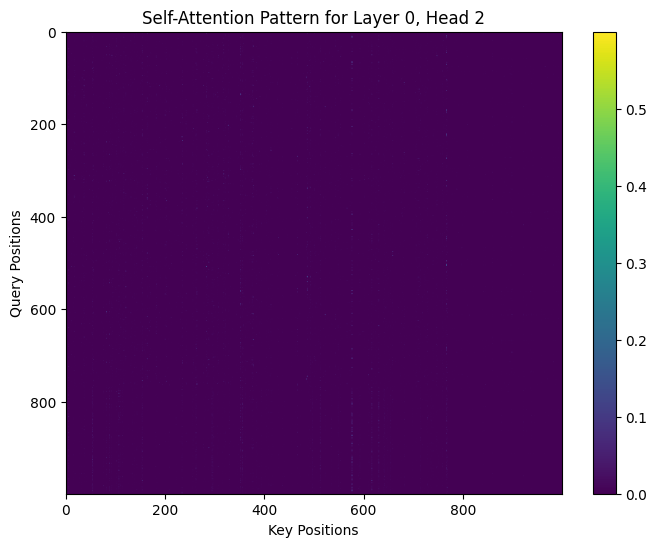

In [36]:
# Add batch dimension to your inputs
x, c, y = test_dataset[0]
x = x.unsqueeze(0) # Shape: [1, 1000]
c = c.unsqueeze(0) # Shape: [1, 50]
y = y.unsqueeze(0) # Shape: [1, 1000]

with torch.no_grad():
    logits, cache = model.run_with_cache(x, c, return_type="both")

# Choose the layer and head to visualize
layer = 0  # Change to the desired layer index
head = 2  # Change to the desired head index

# Access attention patterns for the specified layer
attn_patterns = cache[f'blocks.{layer}.attn.hook_pattern']  # Shape: [batch_size, n_heads, seq_len, seq_len]

# Extract the attention pattern for the specified head and sample
attn = attn_patterns[0, head].cpu().numpy()  # Shape: [seq_len, seq_len]

plt.figure(figsize=(8, 6))
plt.imshow(attn, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title(f'Self-Attention Pattern for Layer {layer}, Head {head}')
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.show()

In [17]:
# Add batch dimension to your inputs
x, c, y = test_dataset[0]
x = x.unsqueeze(0) # Shape: [1, 1000]
c = c.unsqueeze(0) # Shape: [1, 50]
y = y.unsqueeze(0) # Shape: [1, 1000]

with torch.no_grad():
    logits, cache = model.run_with_cache(x, c, return_type="both")

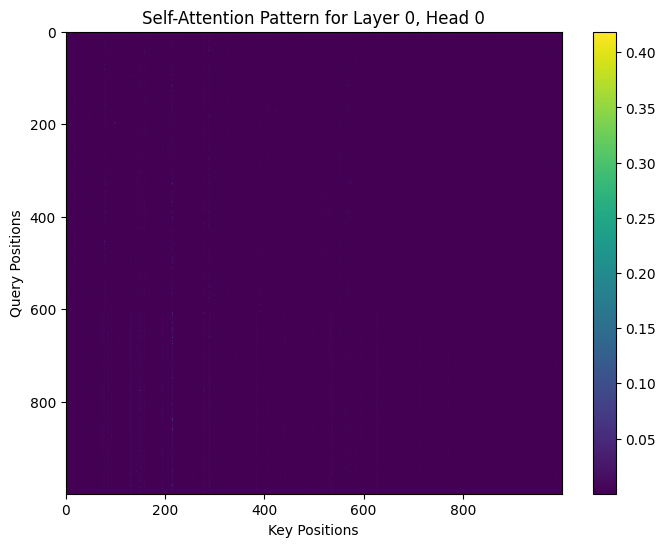

In [18]:
# Choose the layer and head to visualize
layer = 0  # Change to the desired layer index
head = 0   # Change to the desired head index

# Access attention patterns for the specified layer
attn_patterns = cache[f'blocks.{layer}.attn.hook_pattern']  # Shape: [batch_size, n_heads, seq_len, seq_len]

# Extract the attention pattern for the specified head and sample
attn = attn_patterns[0, head].cpu().numpy()  # Shape: [seq_len, seq_len]

plt.figure(figsize=(8, 6))
plt.imshow(attn, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title(f'Self-Attention Pattern for Layer {layer}, Head {head}')
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.show()